In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight
import warnings

import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Reshape
from keras.layers import Dense, Activation, Flatten, Convolution1D, Dropout,MaxPooling1D
from tensorflow.keras.optimizers import Adam 
from keras.callbacks import LearningRateScheduler

import itertools
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, label_ranking_average_precision_score, label_ranking_loss, coverage_error

from tensorflow.keras.layers import BatchNormalization
import cv2
from tensorflow.keras.optimizers import Adam , Adadelta

warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
train = pd.read_csv("../input/heartbeat/mitbih_train.csv" , header = None)
test = pd.read_csv("../input/heartbeat/mitbih_test.csv" , header = None)
display_test = pd.read_csv("../input/displayxai/display_XAI.csv" , header = None)

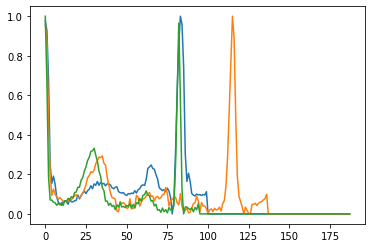

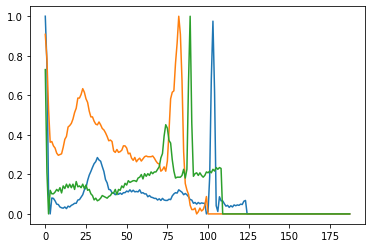

In [3]:
for i in range(3): plt.plot(train.iloc[i])
plt.show()
for i in range(3): plt.plot(test.iloc[i])
plt.show()

In [4]:
train.rename(columns={187:"Class"}, inplace=True)
test.rename(columns={187:"Class"}, inplace=True)
display_test.rename(columns={187:"Class"}, inplace=True)

In [5]:
train['Class'].unique()

array([0., 1., 2., 3., 4.])

In [6]:
test['Class'].unique()

array([0., 1., 2., 3., 4.])

In [7]:
mapping = {     0. : 'Normal Beat',
               1. : 'Supraventricular premature beat',
               2. : 'Premature ventricular contraction',
               3. : 'Fusion of ventricular',
               4. : 'Unclassifiable beat'}

In [8]:
train['label'] = train.iloc[:, -1].map(mapping)
test['label'] = test.iloc[:, -1].map(mapping)
display_test['label'] = display_test.iloc[:, -1].map(mapping)



In [9]:
from sklearn.utils import resample

df_1=train[train['Class']==1]
df_2=train[train['Class']==2]
df_3=train[train['Class']==3]
df_4=train[train['Class']==4]
df_0=(train[train['Class']==0]).sample(n=20000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=20000,random_state=123)
df_2_upsample=resample(df_2,replace=True,n_samples=20000,random_state=124)
df_3_upsample=resample(df_3,replace=True,n_samples=20000,random_state=125)
df_4_upsample=resample(df_4,replace=True,n_samples=20000,random_state=126)

train=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

In [10]:
X_train=train.iloc[:,:186].values
X_test=test.iloc[:,:186].values
X_display = display_test.iloc[: , :186].values

In [11]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(k_neighbors=1)
X_train, y_train = oversample.fit_resample(X_train, train["Class"])


In [12]:
from collections import Counter

counter = Counter(y_train)
print(counter)

Counter({0.0: 20000, 1.0: 20000, 2.0: 20000, 3.0: 20000, 4.0: 20000})


In [13]:
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)
X_display = X_display.reshape(len(X_display), X_display.shape[1],1)

In [14]:
target_test=test["Class"]
target_display = display_test["Class"]

In [15]:
y_train= np.array(y_train).reshape(-1,1)
y_test= np.array(target_test).reshape(-1,1)
y_display = np.array(target_display).reshape(-1,1)

In [16]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
encoder_df1 = pd.DataFrame(enc.fit_transform(y_train).toarray())
encoder_df2 = pd.DataFrame(enc.fit_transform(y_test).toarray())
encoder_df4 = pd.DataFrame(enc.fit_transform(y_display).toarray())




In [17]:
y_train = np.array(encoder_df1)
y_test = np.array(encoder_df2)
y_display = np.array(encoder_df4)

In [18]:
from sklearn.model_selection import train_test_split
X_test, X_validate, y_test, y_validate = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [19]:
import tensorflow
X_train =tensorflow.convert_to_tensor(X_train, dtype=tensorflow.float32)
y_train = tensorflow.convert_to_tensor(y_train, dtype=tensorflow.float32)

X_test = tensorflow.convert_to_tensor(X_test, dtype=tensorflow.float32)
y_test = tensorflow.convert_to_tensor(y_test, dtype=tensorflow.float32)

X_validate = tensorflow.convert_to_tensor(X_validate, dtype=tensorflow.float32)
y_validate = tensorflow.convert_to_tensor(y_validate, dtype=tensorflow.float32)

X_display = tensorflow.convert_to_tensor(X_display, dtype=tensorflow.float32)
y_display = tensorflow.convert_to_tensor(y_display, dtype=tensorflow.float32)


2022-07-23 10:43:30.118273: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-23 10:43:30.126942: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-23 10:43:30.127711: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-23 10:43:30.130028: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [20]:
X_train.shape

TensorShape([100000, 186, 1])

In [21]:
n_obs, feature, depth = X_train.shape
batch_size = 500

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv1D, MaxPool1D, Dropout
from tensorflow.keras.optimizers import Adam


In [23]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense, Conv1D, MaxPool1D, Dropout

In [24]:

def objective(trial):
   
    model = Sequential()

    # Parameter 
    filters=trial.suggest_categorical("filters", [ 16, 32 , 64 ])
    kernel_size=trial.suggest_categorical("kernel_size", [3, 5 ,7])
    strides=trial.suggest_categorical("strides", [3, 5,7])
    activation=trial.suggest_categorical("activation", ["relu", "linear" ,"sigmoid", "tanh" ])
    #learning_rate = trial.suggest_float("learning_rate", 0.1, 0.3)
    epochs = trial.suggest_categorical("epochs", [20,40,50,75])
    dense = trial.suggest_categorical("dense" , [128,256,512,1024])
    dropout = trial.suggest_float("dropout",  0.2 ,0.5)
    pool_size=trial.suggest_categorical("pool_size", [3, 4 ,5 ])
    optimizer = trial.suggest_categorical("optimizer", ["adam", "Adadelta"])

 


        #First CNN layer  with 32 filters, conv window 5, relu activation and same padding
    model.add( 
        Conv1D (filters=filters,
                     kernel_size=kernel_size,
                     strides=strides,
                     padding='same',
                     activation=activation,
                     input_shape = (X_train.shape[1],1) ) )

    
    #Second CNN layer  with 64 filters, conv window 5, relu activation and same padding
    model.add(Conv1D(filters=filters,
                     kernel_size=kernel_size,
                     strides=strides,
                     padding='same',
                     activation=activation
                     ))
    
    #Third CNN layer with 64 filters, conv window 5, relu activation and same padding
    model.add(Conv1D(filters=filters,
                     kernel_size=kernel_size,
                     strides=strides,
                     padding='same',
                     activation=activation
                     ))
    

    #Fourth CNN layer with Max pooling
    model.add(MaxPool1D(pool_size=pool_size,
                        strides=strides,
                        padding='same'))
    
    
    model.add(Dropout(dropout))
    model.add(Flatten())
        #Add a dense layer with 512 neurons
    model.add(Dense(units = dense , activation=activation))

    #Add a dense layer with 1024 neurons
    model.add(Dense(units = dense , activation=activation))
    model.add(Dense(5, activation="softmax"))

    # We compile our model with a sampled learning rate.


    model.compile(
        loss="categorical_crossentropy",
        optimizer= optimizer,
        metrics=["accuracy"]
    )
        
    my_callbacks = [
            keras.callbacks.ModelCheckpoint(filepath='model_CnnV2.h5' , monitor = 'val_loss' , save_best_only=True)
       ]

    batch_size = trial.suggest_categorical("batch_size",[128 , 256,512])
    
    model.fit(
        X_train,
        y_train,
        validation_data=(X_validate, y_validate), # Change X_tets , y_test >>> X_validate , y_Validate
        shuffle=True,
        batch_size=batch_size,
        epochs=epochs,
        verbose=False,
    )

    # Evaluate the model accuracy on the validation set.
    score = model.evaluate(X_test, y_test, verbose=1)
    return score[0] 

In [25]:
!pip install optuna

In [26]:
import optuna
from optuna.integration import KerasPruningCallback
from optuna.trial import TrialState

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)     #n_trials = 100

[I 2022-07-23 10:43:41,282] A new study created in memory with name: no-name-741de690-4ec1-4b26-9dc4-8c03b416859a
2022-07-23 10:43:41.477059: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-07-23 10:43:42.318887: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


343/343 [==============================] - 1s 3ms/step - loss: 1.1511 - accuracy: 0.4900


[I 2022-07-23 10:44:54,694] Trial 0 finished with value: 1.1510869264602661 and parameters: {'filters': 64, 'kernel_size': 7, 'strides': 7, 'activation': 'tanh', 'epochs': 50, 'dense': 256, 'dropout': 0.3169894296240471, 'pool_size': 5, 'optimizer': 'Adadelta', 'batch_size': 256}. Best is trial 0 with value: 1.1510869264602661.


343/343 [==============================] - 1s 3ms/step - loss: 1.6138 - accuracy: 0.0264


[I 2022-07-23 10:46:18,758] Trial 1 finished with value: 1.6137549877166748 and parameters: {'filters': 16, 'kernel_size': 7, 'strides': 5, 'activation': 'sigmoid', 'epochs': 50, 'dense': 1024, 'dropout': 0.2585457937960761, 'pool_size': 5, 'optimizer': 'Adadelta', 'batch_size': 256}. Best is trial 0 with value: 1.1510869264602661.


343/343 [==============================] - 1s 2ms/step - loss: 0.1484 - accuracy: 0.9505


[I 2022-07-23 10:47:42,581] Trial 2 finished with value: 0.14844593405723572 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 5, 'activation': 'tanh', 'epochs': 20, 'dense': 128, 'dropout': 0.2108183523371455, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 256}. Best is trial 2 with value: 0.14844593405723572.


343/343 [==============================] - 1s 2ms/step - loss: 0.1366 - accuracy: 0.9699


[I 2022-07-23 10:52:21,726] Trial 3 finished with value: 0.13660989701747894 and parameters: {'filters': 64, 'kernel_size': 7, 'strides': 5, 'activation': 'relu', 'epochs': 75, 'dense': 128, 'dropout': 0.3764761239655525, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 128}. Best is trial 3 with value: 0.13660989701747894.


343/343 [==============================] - 1s 2ms/step - loss: 0.7050 - accuracy: 0.7368


[I 2022-07-23 10:54:03,825] Trial 4 finished with value: 0.7050150036811829 and parameters: {'filters': 32, 'kernel_size': 3, 'strides': 5, 'activation': 'linear', 'epochs': 40, 'dense': 512, 'dropout': 0.21959148917919696, 'pool_size': 4, 'optimizer': 'adam', 'batch_size': 128}. Best is trial 3 with value: 0.13660989701747894.


343/343 [==============================] - 1s 3ms/step - loss: 0.2368 - accuracy: 0.9159


[I 2022-07-23 10:57:06,484] Trial 5 finished with value: 0.23677469789981842 and parameters: {'filters': 32, 'kernel_size': 3, 'strides': 7, 'activation': 'tanh', 'epochs': 75, 'dense': 256, 'dropout': 0.43455937522493515, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 128}. Best is trial 3 with value: 0.13660989701747894.


343/343 [==============================] - 1s 2ms/step - loss: 1.4402 - accuracy: 0.3570


[I 2022-07-23 10:57:58,740] Trial 6 finished with value: 1.440199375152588 and parameters: {'filters': 32, 'kernel_size': 7, 'strides': 7, 'activation': 'tanh', 'epochs': 20, 'dense': 256, 'dropout': 0.35515333042193886, 'pool_size': 4, 'optimizer': 'Adadelta', 'batch_size': 128}. Best is trial 3 with value: 0.13660989701747894.


343/343 [==============================] - 1s 2ms/step - loss: 0.1662 - accuracy: 0.9425


[I 2022-07-23 11:02:36,253] Trial 7 finished with value: 0.1661847084760666 and parameters: {'filters': 64, 'kernel_size': 7, 'strides': 5, 'activation': 'sigmoid', 'epochs': 75, 'dense': 256, 'dropout': 0.47814484753770836, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 128}. Best is trial 3 with value: 0.13660989701747894.


343/343 [==============================] - 1s 3ms/step - loss: 0.9211 - accuracy: 0.6439


[I 2022-07-23 11:05:00,049] Trial 8 finished with value: 0.9211190938949585 and parameters: {'filters': 16, 'kernel_size': 3, 'strides': 5, 'activation': 'linear', 'epochs': 50, 'dense': 1024, 'dropout': 0.39404338979118103, 'pool_size': 5, 'optimizer': 'adam', 'batch_size': 128}. Best is trial 3 with value: 0.13660989701747894.


343/343 [==============================] - 1s 2ms/step - loss: 0.2031 - accuracy: 0.9248


[I 2022-07-23 11:05:36,414] Trial 9 finished with value: 0.20311588048934937 and parameters: {'filters': 64, 'kernel_size': 3, 'strides': 5, 'activation': 'relu', 'epochs': 50, 'dense': 256, 'dropout': 0.3669158118833894, 'pool_size': 5, 'optimizer': 'adam', 'batch_size': 512}. Best is trial 3 with value: 0.13660989701747894.


343/343 [==============================] - 1s 3ms/step - loss: 1.5575 - accuracy: 0.4057


[I 2022-07-23 11:09:24,193] Trial 10 finished with value: 1.5574828386306763 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 3, 'activation': 'relu', 'epochs': 75, 'dense': 128, 'dropout': 0.2783538232748882, 'pool_size': 3, 'optimizer': 'Adadelta', 'batch_size': 512}. Best is trial 3 with value: 0.13660989701747894.


343/343 [==============================] - 1s 2ms/step - loss: 0.1363 - accuracy: 0.9593


[I 2022-07-23 11:10:47,542] Trial 11 finished with value: 0.13634812831878662 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 3, 'activation': 'relu', 'epochs': 20, 'dense': 128, 'dropout': 0.2012896871118214, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 256}. Best is trial 11 with value: 0.13634812831878662.


343/343 [==============================] - 1s 2ms/step - loss: 0.1182 - accuracy: 0.9626


[I 2022-07-23 11:12:11,752] Trial 12 finished with value: 0.11817851662635803 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 3, 'activation': 'relu', 'epochs': 20, 'dense': 128, 'dropout': 0.3108923164268902, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 256}. Best is trial 12 with value: 0.11817851662635803.


343/343 [==============================] - 1s 2ms/step - loss: 0.1160 - accuracy: 0.9649


[I 2022-07-23 11:13:20,845] Trial 13 finished with value: 0.11598251014947891 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 3, 'activation': 'relu', 'epochs': 20, 'dense': 128, 'dropout': 0.30013957781763767, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 256}. Best is trial 13 with value: 0.11598251014947891.


343/343 [==============================] - 1s 2ms/step - loss: 0.1387 - accuracy: 0.9556


[I 2022-07-23 11:14:29,915] Trial 14 finished with value: 0.13874097168445587 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 3, 'activation': 'relu', 'epochs': 20, 'dense': 128, 'dropout': 0.3204005926735086, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 256}. Best is trial 13 with value: 0.11598251014947891.


343/343 [==============================] - 1s 2ms/step - loss: 0.1867 - accuracy: 0.9286


[I 2022-07-23 11:14:56,943] Trial 15 finished with value: 0.18671560287475586 and parameters: {'filters': 16, 'kernel_size': 5, 'strides': 3, 'activation': 'relu', 'epochs': 20, 'dense': 512, 'dropout': 0.2904786702898406, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 256}. Best is trial 13 with value: 0.11598251014947891.


343/343 [==============================] - 1s 2ms/step - loss: 0.1637 - accuracy: 0.9583


[I 2022-07-23 11:17:20,732] Trial 16 finished with value: 0.16374355554580688 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 3, 'activation': 'relu', 'epochs': 40, 'dense': 128, 'dropout': 0.25135031250456574, 'pool_size': 4, 'optimizer': 'adam', 'batch_size': 256}. Best is trial 13 with value: 0.11598251014947891.


343/343 [==============================] - 1s 3ms/step - loss: 0.1248 - accuracy: 0.9595


[I 2022-07-23 11:18:44,206] Trial 17 finished with value: 0.12481901049613953 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 3, 'activation': 'relu', 'epochs': 20, 'dense': 128, 'dropout': 0.4123853558063467, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 512}. Best is trial 13 with value: 0.11598251014947891.


343/343 [==============================] - 1s 2ms/step - loss: 1.6081 - accuracy: 0.8233


[I 2022-07-23 11:19:16,625] Trial 18 finished with value: 1.6080927848815918 and parameters: {'filters': 32, 'kernel_size': 5, 'strides': 3, 'activation': 'sigmoid', 'epochs': 20, 'dense': 128, 'dropout': 0.32875258515245087, 'pool_size': 3, 'optimizer': 'Adadelta', 'batch_size': 256}. Best is trial 13 with value: 0.11598251014947891.


343/343 [==============================] - 1s 3ms/step - loss: 0.5657 - accuracy: 0.7852


[I 2022-07-23 11:19:59,774] Trial 19 finished with value: 0.5656757354736328 and parameters: {'filters': 16, 'kernel_size': 5, 'strides': 3, 'activation': 'linear', 'epochs': 20, 'dense': 1024, 'dropout': 0.3019721632311387, 'pool_size': 4, 'optimizer': 'adam', 'batch_size': 256}. Best is trial 13 with value: 0.11598251014947891.


343/343 [==============================] - 1s 2ms/step - loss: 0.1115 - accuracy: 0.9724


[I 2022-07-23 11:22:17,038] Trial 20 finished with value: 0.11150483042001724 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 3, 'activation': 'relu', 'epochs': 40, 'dense': 512, 'dropout': 0.2515708225552526, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 256}. Best is trial 20 with value: 0.11150483042001724.


343/343 [==============================] - 1s 2ms/step - loss: 0.1026 - accuracy: 0.9795


[I 2022-07-23 11:24:34,197] Trial 21 finished with value: 0.1025879830121994 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 3, 'activation': 'relu', 'epochs': 40, 'dense': 512, 'dropout': 0.2458730664010385, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 256}. Best is trial 21 with value: 0.1025879830121994.


343/343 [==============================] - 1s 2ms/step - loss: 0.1170 - accuracy: 0.9760


[I 2022-07-23 11:26:51,723] Trial 22 finished with value: 0.1169968694448471 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 3, 'activation': 'relu', 'epochs': 40, 'dense': 512, 'dropout': 0.23960925284234125, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 256}. Best is trial 21 with value: 0.1025879830121994.


343/343 [==============================] - 1s 2ms/step - loss: 0.1109 - accuracy: 0.9775


[I 2022-07-23 11:29:10,030] Trial 23 finished with value: 0.11085731536149979 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 3, 'activation': 'relu', 'epochs': 40, 'dense': 512, 'dropout': 0.2776480438732505, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 256}. Best is trial 21 with value: 0.1025879830121994.


343/343 [==============================] - 1s 2ms/step - loss: 0.1104 - accuracy: 0.9730


[I 2022-07-23 11:31:33,893] Trial 24 finished with value: 0.1104440912604332 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 3, 'activation': 'relu', 'epochs': 40, 'dense': 512, 'dropout': 0.2674485171585919, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 256}. Best is trial 21 with value: 0.1025879830121994.


343/343 [==============================] - 1s 2ms/step - loss: 0.1318 - accuracy: 0.9658


[I 2022-07-23 11:33:57,703] Trial 25 finished with value: 0.1318037360906601 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 3, 'activation': 'relu', 'epochs': 40, 'dense': 512, 'dropout': 0.27364441525455097, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 512}. Best is trial 21 with value: 0.1025879830121994.


343/343 [==============================] - 1s 2ms/step - loss: 1.5701 - accuracy: 0.3613


[I 2022-07-23 11:34:52,007] Trial 26 finished with value: 1.5701333284378052 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 7, 'activation': 'relu', 'epochs': 40, 'dense': 512, 'dropout': 0.2328814199086812, 'pool_size': 3, 'optimizer': 'Adadelta', 'batch_size': 256}. Best is trial 21 with value: 0.1025879830121994.


343/343 [==============================] - 1s 2ms/step - loss: 0.2537 - accuracy: 0.9174


[I 2022-07-23 11:37:07,971] Trial 27 finished with value: 0.2537028193473816 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 3, 'activation': 'linear', 'epochs': 40, 'dense': 512, 'dropout': 0.268923757290927, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 256}. Best is trial 21 with value: 0.1025879830121994.


343/343 [==============================] - 1s 2ms/step - loss: 0.4231 - accuracy: 0.8621


[I 2022-07-23 11:38:31,262] Trial 28 finished with value: 0.4230712950229645 and parameters: {'filters': 16, 'kernel_size': 5, 'strides': 3, 'activation': 'sigmoid', 'epochs': 40, 'dense': 512, 'dropout': 0.33345180104646494, 'pool_size': 5, 'optimizer': 'adam', 'batch_size': 256}. Best is trial 21 with value: 0.1025879830121994.


343/343 [==============================] - 1s 2ms/step - loss: 1.3792 - accuracy: 0.2707


[I 2022-07-23 11:39:26,651] Trial 29 finished with value: 1.3792415857315063 and parameters: {'filters': 32, 'kernel_size': 3, 'strides': 7, 'activation': 'tanh', 'epochs': 40, 'dense': 512, 'dropout': 0.23149710786325303, 'pool_size': 4, 'optimizer': 'Adadelta', 'batch_size': 256}. Best is trial 21 with value: 0.1025879830121994.


343/343 [==============================] - 1s 2ms/step - loss: 0.1143 - accuracy: 0.9772


[I 2022-07-23 11:41:57,393] Trial 30 finished with value: 0.11429671198129654 and parameters: {'filters': 64, 'kernel_size': 7, 'strides': 3, 'activation': 'relu', 'epochs': 40, 'dense': 512, 'dropout': 0.2811671307833008, 'pool_size': 5, 'optimizer': 'adam', 'batch_size': 512}. Best is trial 21 with value: 0.1025879830121994.


343/343 [==============================] - 1s 2ms/step - loss: 0.1101 - accuracy: 0.9737


[I 2022-07-23 11:44:15,817] Trial 31 finished with value: 0.11006373167037964 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 3, 'activation': 'relu', 'epochs': 40, 'dense': 512, 'dropout': 0.2512229101110534, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 256}. Best is trial 21 with value: 0.1025879830121994.


343/343 [==============================] - 1s 2ms/step - loss: 0.1086 - accuracy: 0.9770


[I 2022-07-23 11:46:33,165] Trial 32 finished with value: 0.10860192030668259 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 3, 'activation': 'relu', 'epochs': 40, 'dense': 512, 'dropout': 0.25797589060737913, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 256}. Best is trial 21 with value: 0.1025879830121994.


343/343 [==============================] - 1s 2ms/step - loss: 0.1266 - accuracy: 0.9724


[I 2022-07-23 11:48:51,128] Trial 33 finished with value: 0.12655103206634521 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 3, 'activation': 'relu', 'epochs': 40, 'dense': 512, 'dropout': 0.25916112979503864, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 256}. Best is trial 21 with value: 0.1025879830121994.


343/343 [==============================] - 1s 2ms/step - loss: 0.1096 - accuracy: 0.9793


[I 2022-07-23 11:51:15,331] Trial 34 finished with value: 0.1096232682466507 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 3, 'activation': 'relu', 'epochs': 40, 'dense': 512, 'dropout': 0.21445740745434227, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 256}. Best is trial 21 with value: 0.1025879830121994.


343/343 [==============================] - 1s 2ms/step - loss: 0.1324 - accuracy: 0.9595


[I 2022-07-23 11:54:00,910] Trial 35 finished with value: 0.132406547665596 and parameters: {'filters': 64, 'kernel_size': 7, 'strides': 3, 'activation': 'sigmoid', 'epochs': 40, 'dense': 512, 'dropout': 0.22216476422643178, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 256}. Best is trial 21 with value: 0.1025879830121994.


343/343 [==============================] - 1s 2ms/step - loss: 1.1542 - accuracy: 0.4289


[I 2022-07-23 11:55:24,673] Trial 36 finished with value: 1.1542284488677979 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 7, 'activation': 'tanh', 'epochs': 50, 'dense': 1024, 'dropout': 0.2150999164527256, 'pool_size': 3, 'optimizer': 'Adadelta', 'batch_size': 256}. Best is trial 21 with value: 0.1025879830121994.


343/343 [==============================] - 1s 2ms/step - loss: 0.1801 - accuracy: 0.9515


[I 2022-07-23 11:56:48,006] Trial 37 finished with value: 0.18011030554771423 and parameters: {'filters': 32, 'kernel_size': 5, 'strides': 3, 'activation': 'relu', 'epochs': 40, 'dense': 512, 'dropout': 0.20182812422938473, 'pool_size': 5, 'optimizer': 'adam', 'batch_size': 256}. Best is trial 21 with value: 0.1025879830121994.


343/343 [==============================] - 1s 2ms/step - loss: 0.8282 - accuracy: 0.6771


[I 2022-07-23 11:59:11,872] Trial 38 finished with value: 0.8282499313354492 and parameters: {'filters': 16, 'kernel_size': 3, 'strides': 5, 'activation': 'linear', 'epochs': 40, 'dense': 512, 'dropout': 0.24557215515605288, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 128}. Best is trial 21 with value: 0.1025879830121994.


343/343 [==============================] - 1s 2ms/step - loss: 0.1254 - accuracy: 0.9693


[I 2022-07-23 12:00:57,845] Trial 39 finished with value: 0.12538066506385803 and parameters: {'filters': 64, 'kernel_size': 7, 'strides': 7, 'activation': 'tanh', 'epochs': 75, 'dense': 512, 'dropout': 0.226454145730486, 'pool_size': 4, 'optimizer': 'adam', 'batch_size': 256}. Best is trial 21 with value: 0.1025879830121994.


343/343 [==============================] - 1s 3ms/step - loss: 1.3435 - accuracy: 0.4762


[I 2022-07-23 12:04:21,302] Trial 40 finished with value: 1.343474268913269 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 3, 'activation': 'relu', 'epochs': 40, 'dense': 256, 'dropout': 0.21802766793021264, 'pool_size': 3, 'optimizer': 'Adadelta', 'batch_size': 128}. Best is trial 21 with value: 0.1025879830121994.


343/343 [==============================] - 1s 2ms/step - loss: 0.1097 - accuracy: 0.9758


[I 2022-07-23 12:06:38,292] Trial 41 finished with value: 0.10965511947870255 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 3, 'activation': 'relu', 'epochs': 40, 'dense': 512, 'dropout': 0.24116808768417386, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 256}. Best is trial 21 with value: 0.1025879830121994.


343/343 [==============================] - 1s 2ms/step - loss: 0.0915 - accuracy: 0.9726


[I 2022-07-23 12:09:01,627] Trial 42 finished with value: 0.09152194112539291 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 3, 'activation': 'relu', 'epochs': 40, 'dense': 512, 'dropout': 0.497007663122247, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 256}. Best is trial 42 with value: 0.09152194112539291.


343/343 [==============================] - 1s 2ms/step - loss: 0.1051 - accuracy: 0.9720


[I 2022-07-23 12:11:53,173] Trial 43 finished with value: 0.1050681322813034 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 3, 'activation': 'relu', 'epochs': 50, 'dense': 512, 'dropout': 0.49128451089803027, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 256}. Best is trial 42 with value: 0.09152194112539291.


343/343 [==============================] - 1s 2ms/step - loss: 0.1711 - accuracy: 0.9368


[I 2022-07-23 12:13:16,985] Trial 44 finished with value: 0.1710805594921112 and parameters: {'filters': 64, 'kernel_size': 3, 'strides': 5, 'activation': 'relu', 'epochs': 50, 'dense': 1024, 'dropout': 0.49492339873464486, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 256}. Best is trial 42 with value: 0.09152194112539291.


343/343 [==============================] - 1s 2ms/step - loss: 0.1225 - accuracy: 0.9683


[I 2022-07-23 12:16:41,175] Trial 45 finished with value: 0.12251279503107071 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 3, 'activation': 'relu', 'epochs': 50, 'dense': 512, 'dropout': 0.45589100997904886, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 256}. Best is trial 42 with value: 0.09152194112539291.


343/343 [==============================] - 1s 2ms/step - loss: 0.1542 - accuracy: 0.9475


[I 2022-07-23 12:18:00,162] Trial 46 finished with value: 0.1542438268661499 and parameters: {'filters': 32, 'kernel_size': 5, 'strides': 3, 'activation': 'relu', 'epochs': 50, 'dense': 256, 'dropout': 0.4619799143485092, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 256}. Best is trial 42 with value: 0.09152194112539291.


343/343 [==============================] - 1s 3ms/step - loss: 0.1602 - accuracy: 0.9456


[I 2022-07-23 12:21:23,957] Trial 47 finished with value: 0.16023194789886475 and parameters: {'filters': 64, 'kernel_size': 7, 'strides': 5, 'activation': 'sigmoid', 'epochs': 50, 'dense': 512, 'dropout': 0.48888744607723744, 'pool_size': 5, 'optimizer': 'adam', 'batch_size': 128}. Best is trial 42 with value: 0.09152194112539291.


343/343 [==============================] - 1s 2ms/step - loss: 0.0967 - accuracy: 0.9761


[I 2022-07-23 12:25:47,333] Trial 48 finished with value: 0.09669654816389084 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 3, 'activation': 'relu', 'epochs': 75, 'dense': 512, 'dropout': 0.42848239777123076, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 512}. Best is trial 42 with value: 0.09152194112539291.


343/343 [==============================] - 1s 3ms/step - loss: 0.4720 - accuracy: 0.8542


[I 2022-07-23 12:26:43,667] Trial 49 finished with value: 0.4719695448875427 and parameters: {'filters': 16, 'kernel_size': 5, 'strides': 3, 'activation': 'linear', 'epochs': 75, 'dense': 512, 'dropout': 0.4374391300615433, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 512}. Best is trial 42 with value: 0.09152194112539291.


343/343 [==============================] - 1s 2ms/step - loss: 0.1355 - accuracy: 0.9557


[I 2022-07-23 12:27:48,177] Trial 50 finished with value: 0.135539248585701 and parameters: {'filters': 64, 'kernel_size': 3, 'strides': 3, 'activation': 'relu', 'epochs': 75, 'dense': 256, 'dropout': 0.4747799929353762, 'pool_size': 4, 'optimizer': 'adam', 'batch_size': 512}. Best is trial 42 with value: 0.09152194112539291.


343/343 [==============================] - 1s 2ms/step - loss: 0.0910 - accuracy: 0.9798


[I 2022-07-23 12:31:36,241] Trial 51 finished with value: 0.09098610281944275 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 3, 'activation': 'relu', 'epochs': 75, 'dense': 512, 'dropout': 0.40868465664235226, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 512}. Best is trial 51 with value: 0.09098610281944275.


343/343 [==============================] - 1s 2ms/step - loss: 0.0959 - accuracy: 0.9788


[I 2022-07-23 12:35:24,185] Trial 52 finished with value: 0.09587609022855759 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 3, 'activation': 'relu', 'epochs': 75, 'dense': 512, 'dropout': 0.3844967829959158, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 512}. Best is trial 51 with value: 0.09098610281944275.


343/343 [==============================] - 1s 4ms/step - loss: 0.0912 - accuracy: 0.9800


[I 2022-07-23 12:39:13,331] Trial 53 finished with value: 0.09117598831653595 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 3, 'activation': 'relu', 'epochs': 75, 'dense': 512, 'dropout': 0.39430853324265946, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 512}. Best is trial 51 with value: 0.09098610281944275.


343/343 [==============================] - 1s 2ms/step - loss: 0.1107 - accuracy: 0.9746


[I 2022-07-23 12:43:37,132] Trial 54 finished with value: 0.11066355556249619 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 3, 'activation': 'relu', 'epochs': 75, 'dense': 512, 'dropout': 0.3870560366706871, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 512}. Best is trial 51 with value: 0.09098610281944275.


343/343 [==============================] - 1s 2ms/step - loss: 0.1033 - accuracy: 0.9765


[I 2022-07-23 12:47:33,930] Trial 55 finished with value: 0.10325097292661667 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 3, 'activation': 'relu', 'epochs': 75, 'dense': 1024, 'dropout': 0.40960993179970195, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 512}. Best is trial 51 with value: 0.09098610281944275.


343/343 [==============================] - 1s 2ms/step - loss: 0.1188 - accuracy: 0.9714


[I 2022-07-23 12:51:22,727] Trial 56 finished with value: 0.1187639832496643 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 3, 'activation': 'relu', 'epochs': 75, 'dense': 512, 'dropout': 0.35797869310340175, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 512}. Best is trial 51 with value: 0.09098610281944275.


343/343 [==============================] - 1s 3ms/step - loss: 1.1283 - accuracy: 0.5661


[I 2022-07-23 12:52:55,942] Trial 57 finished with value: 1.1282645463943481 and parameters: {'filters': 32, 'kernel_size': 5, 'strides': 3, 'activation': 'tanh', 'epochs': 75, 'dense': 512, 'dropout': 0.4109444874445485, 'pool_size': 3, 'optimizer': 'Adadelta', 'batch_size': 512}. Best is trial 51 with value: 0.09098610281944275.


343/343 [==============================] - 1s 2ms/step - loss: 0.1277 - accuracy: 0.9668


[I 2022-07-23 12:56:19,312] Trial 58 finished with value: 0.1276763379573822 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 5, 'activation': 'relu', 'epochs': 75, 'dense': 512, 'dropout': 0.3775772622419078, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 512}. Best is trial 51 with value: 0.09098610281944275.


343/343 [==============================] - 1s 2ms/step - loss: 0.1186 - accuracy: 0.9685


[I 2022-07-23 12:57:16,494] Trial 59 finished with value: 0.11855732649564743 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 7, 'activation': 'relu', 'epochs': 75, 'dense': 512, 'dropout': 0.4255357992991269, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 512}. Best is trial 51 with value: 0.09098610281944275.


343/343 [==============================] - 1s 2ms/step - loss: 0.3392 - accuracy: 0.8778


[I 2022-07-23 12:58:12,871] Trial 60 finished with value: 0.33921340107917786 and parameters: {'filters': 16, 'kernel_size': 5, 'strides': 3, 'activation': 'relu', 'epochs': 75, 'dense': 512, 'dropout': 0.3986099248411625, 'pool_size': 4, 'optimizer': 'adam', 'batch_size': 512}. Best is trial 51 with value: 0.09098610281944275.


343/343 [==============================] - 1s 2ms/step - loss: 0.1233 - accuracy: 0.9726


[I 2022-07-23 13:02:36,225] Trial 61 finished with value: 0.12325962632894516 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 3, 'activation': 'relu', 'epochs': 75, 'dense': 1024, 'dropout': 0.4083584024039532, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 512}. Best is trial 51 with value: 0.09098610281944275.


343/343 [==============================] - 1s 2ms/step - loss: 0.1117 - accuracy: 0.9739


[I 2022-07-23 13:06:32,771] Trial 62 finished with value: 0.11171901226043701 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 3, 'activation': 'relu', 'epochs': 75, 'dense': 1024, 'dropout': 0.42571606931053285, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 512}. Best is trial 51 with value: 0.09098610281944275.


343/343 [==============================] - 1s 2ms/step - loss: 0.1131 - accuracy: 0.9762


[I 2022-07-23 13:10:29,373] Trial 63 finished with value: 0.1131342425942421 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 3, 'activation': 'relu', 'epochs': 75, 'dense': 1024, 'dropout': 0.36975594701173664, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 512}. Best is trial 51 with value: 0.09098610281944275.


343/343 [==============================] - 1s 3ms/step - loss: 0.1012 - accuracy: 0.9760


[I 2022-07-23 13:14:25,266] Trial 64 finished with value: 0.10123772919178009 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 3, 'activation': 'relu', 'epochs': 75, 'dense': 1024, 'dropout': 0.4408431589000453, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 512}. Best is trial 51 with value: 0.09098610281944275.


343/343 [==============================] - 1s 2ms/step - loss: 0.1608 - accuracy: 0.9466


[I 2022-07-23 13:18:21,591] Trial 65 finished with value: 0.16084207594394684 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 3, 'activation': 'sigmoid', 'epochs': 75, 'dense': 1024, 'dropout': 0.4472844261645753, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 512}. Best is trial 51 with value: 0.09098610281944275.


343/343 [==============================] - 1s 2ms/step - loss: 0.1221 - accuracy: 0.9739


[I 2022-07-23 13:22:07,770] Trial 66 finished with value: 0.12210579961538315 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 3, 'activation': 'relu', 'epochs': 75, 'dense': 128, 'dropout': 0.3461135454718795, 'pool_size': 5, 'optimizer': 'adam', 'batch_size': 512}. Best is trial 51 with value: 0.09098610281944275.


343/343 [==============================] - 1s 2ms/step - loss: 0.2436 - accuracy: 0.9192


[I 2022-07-23 13:26:46,328] Trial 67 finished with value: 0.24364431202411652 and parameters: {'filters': 64, 'kernel_size': 7, 'strides': 3, 'activation': 'linear', 'epochs': 75, 'dense': 512, 'dropout': 0.3901756969216791, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 512}. Best is trial 51 with value: 0.09098610281944275.


343/343 [==============================] - 1s 2ms/step - loss: 1.6129 - accuracy: 0.2027


[I 2022-07-23 13:30:34,054] Trial 68 finished with value: 1.61286199092865 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 3, 'activation': 'relu', 'epochs': 75, 'dense': 256, 'dropout': 0.4257764547485512, 'pool_size': 3, 'optimizer': 'Adadelta', 'batch_size': 512}. Best is trial 51 with value: 0.09098610281944275.


343/343 [==============================] - 1s 2ms/step - loss: 0.0955 - accuracy: 0.9782


[I 2022-07-23 13:34:57,369] Trial 69 finished with value: 0.09546574205160141 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 3, 'activation': 'relu', 'epochs': 75, 'dense': 512, 'dropout': 0.39814587605673485, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 512}. Best is trial 51 with value: 0.09098610281944275.


343/343 [==============================] - 1s 2ms/step - loss: 0.1265 - accuracy: 0.9697


[I 2022-07-23 13:36:11,113] Trial 70 finished with value: 0.1264624297618866 and parameters: {'filters': 64, 'kernel_size': 3, 'strides': 3, 'activation': 'relu', 'epochs': 75, 'dense': 1024, 'dropout': 0.3825339377476965, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 512}. Best is trial 51 with value: 0.09098610281944275.


343/343 [==============================] - 1s 2ms/step - loss: 0.1137 - accuracy: 0.9720


[I 2022-07-23 13:39:59,543] Trial 71 finished with value: 0.11366797238588333 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 3, 'activation': 'relu', 'epochs': 75, 'dense': 512, 'dropout': 0.39752705084217366, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 512}. Best is trial 51 with value: 0.09098610281944275.


343/343 [==============================] - 1s 2ms/step - loss: 0.1016 - accuracy: 0.9762


[I 2022-07-23 13:43:47,213] Trial 72 finished with value: 0.10156571120023727 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 3, 'activation': 'relu', 'epochs': 75, 'dense': 512, 'dropout': 0.4353217210342142, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 512}. Best is trial 51 with value: 0.09098610281944275.


343/343 [==============================] - 1s 2ms/step - loss: 0.1031 - accuracy: 0.9743


[I 2022-07-23 13:47:35,245] Trial 73 finished with value: 0.10312950611114502 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 3, 'activation': 'relu', 'epochs': 75, 'dense': 512, 'dropout': 0.437355722431786, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 512}. Best is trial 51 with value: 0.09098610281944275.


343/343 [==============================] - 1s 2ms/step - loss: 0.1098 - accuracy: 0.9734


[I 2022-07-23 13:51:58,569] Trial 74 finished with value: 0.10977901518344879 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 3, 'activation': 'relu', 'epochs': 75, 'dense': 512, 'dropout': 0.40245528054521057, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 512}. Best is trial 51 with value: 0.09098610281944275.


343/343 [==============================] - 1s 2ms/step - loss: 0.1029 - accuracy: 0.9759


[I 2022-07-23 13:55:46,451] Trial 75 finished with value: 0.1028917133808136 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 3, 'activation': 'relu', 'epochs': 75, 'dense': 512, 'dropout': 0.4204185155187777, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 512}. Best is trial 51 with value: 0.09098610281944275.


343/343 [==============================] - 1s 2ms/step - loss: 0.1420 - accuracy: 0.9500


[I 2022-07-23 13:56:40,442] Trial 76 finished with value: 0.14204569160938263 and parameters: {'filters': 32, 'kernel_size': 5, 'strides': 7, 'activation': 'relu', 'epochs': 75, 'dense': 512, 'dropout': 0.44948220058413835, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 512}. Best is trial 51 with value: 0.09098610281944275.


343/343 [==============================] - 1s 2ms/step - loss: 0.0976 - accuracy: 0.9740


[I 2022-07-23 14:01:04,686] Trial 77 finished with value: 0.09761973470449448 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 3, 'activation': 'tanh', 'epochs': 75, 'dense': 512, 'dropout': 0.46549894331161384, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 512}. Best is trial 51 with value: 0.09098610281944275.


343/343 [==============================] - 1s 2ms/step - loss: 0.2297 - accuracy: 0.9139


[I 2022-07-23 14:02:28,007] Trial 78 finished with value: 0.22971725463867188 and parameters: {'filters': 16, 'kernel_size': 5, 'strides': 3, 'activation': 'tanh', 'epochs': 75, 'dense': 128, 'dropout': 0.47105952952734886, 'pool_size': 4, 'optimizer': 'adam', 'batch_size': 512}. Best is trial 51 with value: 0.09098610281944275.


343/343 [==============================] - 1s 2ms/step - loss: 0.1898 - accuracy: 0.9345


[I 2022-07-23 14:03:30,432] Trial 79 finished with value: 0.1898154616355896 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 3, 'activation': 'tanh', 'epochs': 20, 'dense': 512, 'dropout': 0.4444044757723076, 'pool_size': 5, 'optimizer': 'adam', 'batch_size': 512}. Best is trial 51 with value: 0.09098610281944275.


343/343 [==============================] - 1s 2ms/step - loss: 1.2216 - accuracy: 0.4548


[I 2022-07-23 14:06:27,928] Trial 80 finished with value: 1.2216087579727173 and parameters: {'filters': 64, 'kernel_size': 7, 'strides': 5, 'activation': 'tanh', 'epochs': 75, 'dense': 512, 'dropout': 0.46390783849892436, 'pool_size': 3, 'optimizer': 'Adadelta', 'batch_size': 512}. Best is trial 51 with value: 0.09098610281944275.


343/343 [==============================] - 1s 3ms/step - loss: 0.1041 - accuracy: 0.9725


[I 2022-07-23 14:10:51,722] Trial 81 finished with value: 0.10413602739572525 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 3, 'activation': 'tanh', 'epochs': 75, 'dense': 512, 'dropout': 0.4322098540758705, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 512}. Best is trial 51 with value: 0.09098610281944275.


343/343 [==============================] - 1s 3ms/step - loss: 0.0995 - accuracy: 0.9768


[I 2022-07-23 14:15:15,510] Trial 82 finished with value: 0.09945639967918396 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 3, 'activation': 'relu', 'epochs': 75, 'dense': 512, 'dropout': 0.36736066622057495, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 512}. Best is trial 51 with value: 0.09098610281944275.


343/343 [==============================] - 1s 3ms/step - loss: 0.1009 - accuracy: 0.9710


[I 2022-07-23 14:19:39,300] Trial 83 finished with value: 0.10087110847234726 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 3, 'activation': 'tanh', 'epochs': 75, 'dense': 512, 'dropout': 0.48402158984541577, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 512}. Best is trial 51 with value: 0.09098610281944275.


343/343 [==============================] - 1s 2ms/step - loss: 0.1611 - accuracy: 0.9512


[I 2022-07-23 14:25:04,872] Trial 84 finished with value: 0.16108185052871704 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 3, 'activation': 'tanh', 'epochs': 75, 'dense': 512, 'dropout': 0.48419899675212213, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 128}. Best is trial 51 with value: 0.09098610281944275.


343/343 [==============================] - 1s 2ms/step - loss: 0.1245 - accuracy: 0.9635


[I 2022-07-23 14:28:53,307] Trial 85 finished with value: 0.12451636046171188 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 3, 'activation': 'tanh', 'epochs': 75, 'dense': 512, 'dropout': 0.4988629834513267, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 512}. Best is trial 51 with value: 0.09098610281944275.


343/343 [==============================] - 1s 2ms/step - loss: 0.0973 - accuracy: 0.9753


[I 2022-07-23 14:32:41,074] Trial 86 finished with value: 0.0973125770688057 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 3, 'activation': 'tanh', 'epochs': 75, 'dense': 512, 'dropout': 0.3661677134520438, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 512}. Best is trial 51 with value: 0.09098610281944275.


343/343 [==============================] - 1s 2ms/step - loss: 0.1278 - accuracy: 0.9662


[I 2022-07-23 14:36:29,163] Trial 87 finished with value: 0.1278320997953415 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 3, 'activation': 'tanh', 'epochs': 75, 'dense': 512, 'dropout': 0.3696107000723008, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 512}. Best is trial 51 with value: 0.09098610281944275.


343/343 [==============================] - 1s 2ms/step - loss: 0.4842 - accuracy: 0.8193


[I 2022-07-23 14:36:48,547] Trial 88 finished with value: 0.4842236340045929 and parameters: {'filters': 64, 'kernel_size': 3, 'strides': 3, 'activation': 'sigmoid', 'epochs': 20, 'dense': 512, 'dropout': 0.3582344690214526, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 512}. Best is trial 51 with value: 0.09098610281944275.


343/343 [==============================] - 1s 3ms/step - loss: 0.4696 - accuracy: 0.8422


[I 2022-07-23 14:38:19,512] Trial 89 finished with value: 0.469580739736557 and parameters: {'filters': 32, 'kernel_size': 5, 'strides': 3, 'activation': 'linear', 'epochs': 75, 'dense': 512, 'dropout': 0.3514122838707865, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 512}. Best is trial 51 with value: 0.09098610281944275.


343/343 [==============================] - 1s 2ms/step - loss: 0.1236 - accuracy: 0.9633


[I 2022-07-23 14:42:42,868] Trial 90 finished with value: 0.12360353767871857 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 7, 'activation': 'tanh', 'epochs': 75, 'dense': 512, 'dropout': 0.3439588602509884, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 128}. Best is trial 51 with value: 0.09098610281944275.


343/343 [==============================] - 1s 2ms/step - loss: 0.1108 - accuracy: 0.9718


[I 2022-07-23 14:46:30,372] Trial 91 finished with value: 0.11076224595308304 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 3, 'activation': 'tanh', 'epochs': 75, 'dense': 512, 'dropout': 0.3792266440908013, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 512}. Best is trial 51 with value: 0.09098610281944275.


343/343 [==============================] - 1s 2ms/step - loss: 0.1200 - accuracy: 0.9635


[I 2022-07-23 14:50:53,691] Trial 92 finished with value: 0.1199905127286911 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 3, 'activation': 'tanh', 'epochs': 75, 'dense': 512, 'dropout': 0.4805415645593552, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 512}. Best is trial 51 with value: 0.09098610281944275.


343/343 [==============================] - 1s 2ms/step - loss: 0.1154 - accuracy: 0.9699


[I 2022-07-23 14:54:41,951] Trial 93 finished with value: 0.1154174879193306 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 3, 'activation': 'tanh', 'epochs': 75, 'dense': 512, 'dropout': 0.3621978598933314, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 512}. Best is trial 51 with value: 0.09098610281944275.


343/343 [==============================] - 1s 2ms/step - loss: 0.1058 - accuracy: 0.9713


[I 2022-07-23 14:58:29,549] Trial 94 finished with value: 0.10578146576881409 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 3, 'activation': 'tanh', 'epochs': 75, 'dense': 512, 'dropout': 0.4173047598114996, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 512}. Best is trial 51 with value: 0.09098610281944275.


343/343 [==============================] - 1s 2ms/step - loss: 0.1063 - accuracy: 0.9714


[I 2022-07-23 15:02:16,630] Trial 95 finished with value: 0.10625758022069931 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 3, 'activation': 'tanh', 'epochs': 75, 'dense': 512, 'dropout': 0.40491324975473064, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 512}. Best is trial 51 with value: 0.09098610281944275.


343/343 [==============================] - 1s 2ms/step - loss: 0.1030 - accuracy: 0.9750


[I 2022-07-23 15:06:04,695] Trial 96 finished with value: 0.10301795601844788 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 3, 'activation': 'relu', 'epochs': 75, 'dense': 512, 'dropout': 0.38876857670678044, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 512}. Best is trial 51 with value: 0.09098610281944275.


343/343 [==============================] - 1s 2ms/step - loss: 0.4474 - accuracy: 0.8414


[I 2022-07-23 15:06:56,679] Trial 97 finished with value: 0.4473862946033478 and parameters: {'filters': 16, 'kernel_size': 5, 'strides': 5, 'activation': 'tanh', 'epochs': 75, 'dense': 512, 'dropout': 0.4698251289421065, 'pool_size': 4, 'optimizer': 'adam', 'batch_size': 512}. Best is trial 51 with value: 0.09098610281944275.


343/343 [==============================] - 1s 2ms/step - loss: 1.6237 - accuracy: 0.1472


[I 2022-07-23 15:10:44,058] Trial 98 finished with value: 1.6236541271209717 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 3, 'activation': 'relu', 'epochs': 75, 'dense': 256, 'dropout': 0.37353167520400377, 'pool_size': 5, 'optimizer': 'Adadelta', 'batch_size': 512}. Best is trial 51 with value: 0.09098610281944275.


343/343 [==============================] - 1s 2ms/step - loss: 0.1047 - accuracy: 0.9801


[I 2022-07-23 15:16:07,820] Trial 99 finished with value: 0.10473689436912537 and parameters: {'filters': 64, 'kernel_size': 7, 'strides': 3, 'activation': 'relu', 'epochs': 75, 'dense': 512, 'dropout': 0.39310937972754645, 'pool_size': 3, 'optimizer': 'adam', 'batch_size': 512}. Best is trial 51 with value: 0.09098610281944275.


In [27]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.09098610281944275
  Params: 
    filters: 64
    kernel_size: 5
    strides: 3
    activation: relu
    epochs: 75
    dense: 512
    dropout: 0.40868465664235226
    pool_size: 3
    optimizer: adam
    batch_size: 512


In [28]:
#trial.params["filters"]

In [29]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense, Conv1D, MaxPool1D, Dropout
clf = tf.keras.models.Sequential()

#First CNN layer  with 32 filters, conv window 5, relu activation and same padding
clf.add(Conv1D(filters=trial.params["filters"], kernel_size=trial.params["kernel_size"], padding='same', activation=trial.params["activation"], input_shape = (X_train.shape[1],1)))

#Second CNN layer  with 64 filters, conv window 5, relu activation and same padding
clf.add(Conv1D(filters=trial.params["filters"],  kernel_size=trial.params["kernel_size"], padding='same', activation=trial.params["activation"]))

#Third CNN layer with 64 filters, conv window 5, relu activation and same padding
clf.add(Conv1D(filters=trial.params["filters"], kernel_size=trial.params["kernel_size"], padding='same', activation=trial.params["activation"]))

#Fourth CNN layer with Max pooling
clf.add(MaxPool1D(pool_size=trial.params["pool_size"], strides=trial.params["strides"], padding='same'))
clf.add(Dropout(trial.params["dropout"]))

#Flatten the output
clf.add(Flatten())

#Add a dense layer with 512 neurons
clf.add(Dense(units = trial.params["dense"], activation=trial.params["activation"]))

#Add a dense layer with 1024 neurons
clf.add(Dense(units = trial.params["dense"], activation=trial.params["activation"]))

#Softmax as last layer with two outputs
clf.add(Dense(units = 5, activation='softmax'))

In [30]:
clf.summary()

Model: "sequential_100"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_300 (Conv1D)          (None, 186, 64)           384       
_________________________________________________________________
conv1d_301 (Conv1D)          (None, 186, 64)           20544     
_________________________________________________________________
conv1d_302 (Conv1D)          (None, 186, 64)           20544     
_________________________________________________________________
max_pooling1d_100 (MaxPoolin (None, 62, 64)            0         
_________________________________________________________________
dropout_100 (Dropout)        (None, 62, 64)            0         
_________________________________________________________________
flatten_100 (Flatten)        (None, 3968)              0         
_________________________________________________________________
dense_300 (Dense)            (None, 512)            

In [31]:
clf.compile(
        loss="categorical_crossentropy",
        optimizer= trial.params["optimizer"],
        metrics=["accuracy"]
    )
        
my_callbacks = [
        keras.callbacks.ModelCheckpoint(filepath='model_CnnV2.h5' , monitor = 'val_loss' , save_best_only=True)
    ]

In [32]:
history = clf.fit(
  X_train,
  y_train,
  validation_data=(X_validate, y_validate), # Change X_tets , y_test >>> X_validate , y_Validate
  shuffle=True,
  batch_size=trial.params["batch_size"],
  epochs=trial.params["epochs"],
  verbose=True,
)

Epoch 1/75
196/196 [==============================] - 4s 17ms/step - loss: 0.4200 - accuracy: 0.8408 - val_loss: 0.3215 - val_accuracy: 0.8934
Epoch 2/75
196/196 [==============================] - 3s 16ms/step - loss: 0.1443 - accuracy: 0.9481 - val_loss: 0.2186 - val_accuracy: 0.9202
Epoch 3/75
196/196 [==============================] - 3s 16ms/step - loss: 0.0850 - accuracy: 0.9704 - val_loss: 0.1415 - val_accuracy: 0.9563
Epoch 4/75
196/196 [==============================] - 3s 16ms/step - loss: 0.0575 - accuracy: 0.9801 - val_loss: 0.1272 - val_accuracy: 0.9603
Epoch 5/75
196/196 [==============================] - 3s 16ms/step - loss: 0.0458 - accuracy: 0.9848 - val_loss: 0.1325 - val_accuracy: 0.9605
Epoch 6/75
196/196 [==============================] - 3s 16ms/step - loss: 0.0358 - accuracy: 0.9879 - val_loss: 0.1076 - val_accuracy: 0.9730
Epoch 7/75
196/196 [==============================] - 3s 16ms/step - loss: 0.0300 - accuracy: 0.9901 - val_loss: 0.1441 - val_accuracy: 0.9638

In [33]:
clf.save("model_CnnV2.h5")

In [34]:
y_pred = clf.predict(X_test, batch_size=1000)

In [35]:
y_pred=np.argmax(y_pred, axis=1)
yyy_test = np.argmax(y_test , axis = 1)

In [36]:
print("Model Accuracy is : " , accuracy_score(yyy_test, y_pred) )

Model Accuracy is :  0.9791704732322309


In [37]:
print(classification_report(yyy_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      9012
           1       0.72      0.83      0.77       289
           2       0.97      0.96      0.96       754
           3       0.73      0.88      0.80        78
           4       0.97      0.99      0.98       813

    accuracy                           0.98     10946
   macro avg       0.88      0.93      0.90     10946
weighted avg       0.98      0.98      0.98     10946



In [38]:
print("Evaluate on test data")
results = clf.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", results)


Evaluate on test data
86/86 [==============================] - 0s 4ms/step - loss: 0.1703 - accuracy: 0.9792
test loss, test acc: [0.17034336924552917, 0.9791705012321472]


Text(0, 0.5, 'Loss')

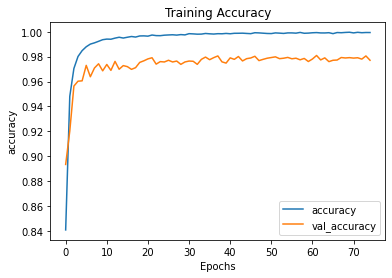

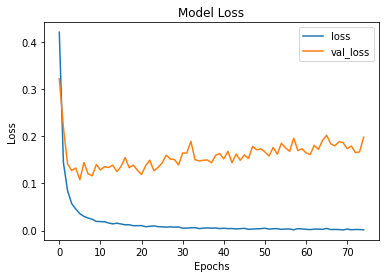

In [39]:
# converting hsitory to dataframe
pd.DataFrame(history.history)

pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')

pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [40]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



Confusion matrix, without normalization


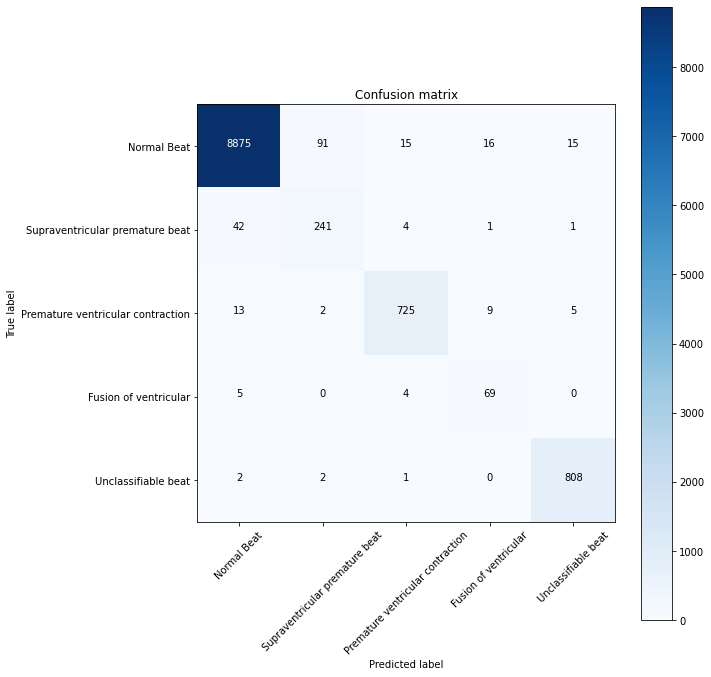

In [41]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(yyy_test, y_pred)


# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['Normal Beat', 'Supraventricular premature beat',
       'Premature ventricular contraction', 'Fusion of ventricular',
       'Unclassifiable beat'],
                      title='Confusion matrix')
plt.show()

In [42]:
from sklearn import metrics
import itertools
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, label_ranking_average_precision_score, label_ranking_loss, coverage_error 


In [43]:
fpr, tpr, thresholds = metrics.roc_curve(yyy_test, y_pred, pos_label=2)

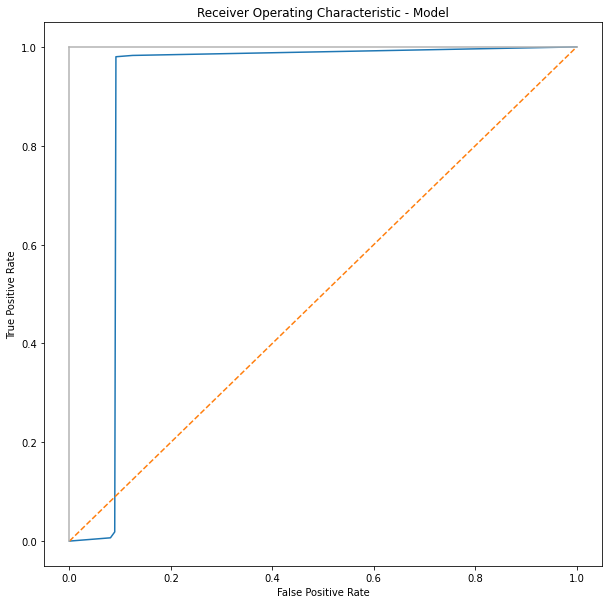

In [44]:
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Model')
plt.plot(fpr, tpr)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [45]:
auc = metrics.auc(fpr, tpr)
print("Auc is : ")
print(auc )


Auc is : 
0.9017530522717148


In [46]:
import tensorflow.keras.backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
#tf.compat.v1.reset_default_graph()


run_eagerly = True



def gradcam(model, x, index, layer_name):
   
    #with tf.Graph().as_default():
    model = tf.keras.models.load_model('./model_CnnV2.h5')
    preds = model.predict(x)
    #model._make_predict_function()
    pred_class = np.argmax(preds[index])
    
    
    #pred_class_name = imagenet_utils.decode_predictions(preds)[0][0][1]
    
   
    pred_output = model.output[:, pred_class]
    
   
    # convolution layer
    last_conv_layer = model.get_layer(layer_name)
    
    #  convolution layer 
    grads = K.gradients(pred_output, last_conv_layer.output)[0]
    
    # feature map 
    #pooled_grads = K.sum(grads, axis=(0, 1, 2))
    pooled_grads = K.sum(grads, axis=(0, 1))
    
    # K.function()  `model.input` `pooled_grads` 
    # `last_conv_layer[0]` Tensorflow feed_dict
    
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[index]])
    
    #  x，feature map convolution layer 
    # feature map
    pooled_grads_value, conv_layer_output_value = iterate([x])
    
    # 將 feature map
    for i in range(pooled_grads_value.shape[0]):
        conv_layer_output_value[:, i] *= (pooled_grads_value[i])
        
    # feature map channel-wise 
    heatmap = np.sum(conv_layer_output_value, axis=-1)
    
    return heatmap, pred_class

In [47]:
def heatmap_():
    heatmap_2d = np.expand_dims(heatmap,1)
    heatmap_2d = cv2.resize(heatmap_2d, (100,188))

    figure = plt.figure(figsize=(80,4))
    ax = figure.add_subplot(111)
    x = np.arange(0, 188, 1)
    ax.plot(x, data*100)
    ax.imshow(np.transpose(heatmap_2d), cmap="Oranges", extent=[0, 188, -10, 120])
    ax.autoscale(False)
    ax.set_xlim(0, 187)
    ax.set_ylim(-10, 110)
    ax.set_title(title)
    plt.show()

In [48]:
def heatmap_3x():
    def preprocess_heatmap(heatmap):
        heatmap_2d = np.expand_dims(heatmap,1)
        heatmap_2d = cv2.resize(heatmap_2d, (100,186))
        heatmap_2d = np.transpose(heatmap_2d)
        return heatmap_2d

    fig, ax = plt.subplots(1,len(name_list)+1,figsize=(20,4))
    x = np.arange(0, 186, 1)
    Collect_attention = list()
    for i in range(1,len(name_list)+1):
        ax[i].plot(x, data*100)
        heatmap_2d = preprocess_heatmap(Collect_heatmap[i-1])
        Collect_attention.append(heatmap_2d[0])
        ax[i].imshow(heatmap_2d, cmap="Oranges", extent=[0, 186, -10, 120])
        ax[i].set_xlim(0, 187)
        ax[i].set_ylim(-10, 110)
        ax[i].set_title(name_list[i-1])
    ax[0].plot(x, data, label="ECG")
    for i in range(len(name_list)):
        ax[0].set_title(title)
        ax[0].plot(x, Collect_attention[i]/np.max(Collect_attention[i]), label=name_list[i])
        ax[0].set_ylim(-0.2, 1)
    ax[0].legend()

    plt.show()

In [49]:
X_display = np.array(X_display).astype(float)

In [50]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
y_display = y_display.tolist()

In [51]:
from tensorflow import keras
model_layer = keras.models.load_model('./model_CnnV2.h5')

2022-07-23 15:20:03.163947: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-23 15:20:03.164836: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-23 15:20:03.165337: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-23 15:20:03.165865: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-23 15:20:03.166303: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [52]:
for i, layer in enumerate(model_layer.layers):
    print(i, layer.name, layer.output_shape)

0 conv1d_300 (None, 186, 64)
1 conv1d_301 (None, 186, 64)
2 conv1d_302 (None, 186, 64)
3 max_pooling1d_100 (None, 62, 64)
4 dropout_100 (None, 62, 64)
5 flatten_100 (None, 3968)
6 dense_300 (None, 512)
7 dense_301 (None, 512)
8 dense_302 (None, 5)


In [2]:
for i in range(10):
    Collect_heatmap = list()
    index = np.random.randint(0,len(X_display))
    name_list = ["conv1d_300" ,"conv1d_302"]
    for name in name_list:
        heatmap, pred_class = gradcam(clf, X_display, index, name)
        Collect_heatmap.append(heatmap)
    data = X_display[index]
    
    if int(y_display[index][0]==1): 
        title = "Normal"
    elif int(y_display[index][1]==1):
        title = "Superaventricular premature beat"
    elif int(y_display[index][2]==1):
        title = "Premature ventricular beat"
    elif int(y_display[index][3]==1):
        title = "Fusion of ventricular beat"
    elif int(y_display[index][4]==1):
        title = "Unclassifiable beat"
   
   
    heatmap_3x()

NameError: name 'np' is not defined